In [1]:
# import packages
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# load English tokenizer, tagger, parser, NER, and word vectors
nlp = spacy.load('en_core_web_sm')

In [2]:
vg = pd.read_json('../Amazon_Data/Video_Games_5.json.gz', lines=True, compression='gzip')

In [3]:
vg.head()

,overall,verified,reviewTime,reviewerID,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image
0,5,True,"10 17, 2015",A1HP7NVNPFMA4N,0700026657,Ambrosia075,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,1445040000,NaN,NaN,NaN
1,4,False,"07 27, 2015",A1JGAP0185YJI6,0700026657,travis,I played it a while but it was alright. The st...,"But in spite of that it was fun, I liked it",1437955200,NaN,NaN,NaN
2,3,True,"02 23, 2015",A1YJWEXHQBWK2B,0700026657,Vincent G. Mezera,ok game.,Three Stars,1424649600,NaN,NaN,NaN
3,2,True,"02 20, 2015",A2204E1TH211HT,0700026657,Grandma KR,"found the game a bit too complicated, not what...",Two Stars,1424390400,NaN,NaN,NaN
4,5,True,"12 25, 2014",A2RF5B5H74JLPE,0700026657,jon,"great game, I love it and have played it since...",love this game,1419465600,NaN,NaN,NaN


In [4]:
vg = vg.loc[:,['overall', 'reviewText']]

## Notes
- 'asin' = product ID
- 'reviewText' = the review text
- 'overall' = the star rating

In [5]:
# view the number of ratings by star value
vg.overall.value_counts()

5    299759
4     93654
3     49146
1     30883
2     24135
Name: overall, dtype: int64

In [6]:
# downsample the data
vg_rmv = vg[(vg.overall != 5) & (vg.overall != 4) & (vg.overall != 3)]
five_idxs = vg[vg.overall == 5].index
four_idxs = vg[vg.overall == 4].index
three_idxs = vg[vg.overall == 3].index

In [8]:
five_filter_idx = np.random.choice(five_idxs, size=28000, replace=False)
four_filter_idx = np.random.choice(four_idxs, size=28000, replace=False)
three_filter_idx = np.random.choice(three_idxs, size=28000, replace=False)

In [9]:
vg_down = pd.concat([vg_rmv, vg.iloc[five_filter_idx], vg.iloc[four_filter_idx], 
                     vg.iloc[three_filter_idx]])

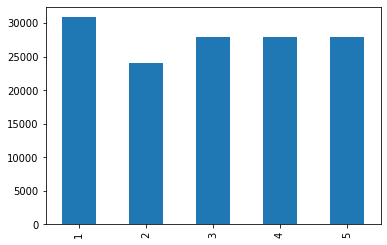

In [10]:
vg_down.overall.value_counts().sort_index().plot(kind='bar')

In [11]:
vg_down.head()

,overall,reviewText
3,2,"found the game a bit too complicated, not what..."
6,1,"I'm an avid gamer, but Anno 2070 is an INSULT ..."
11,1,I've bought and played ALL of the ANNO games s...
17,1,"I'm sure I would love the game, if I could pla..."
18,1,Update June 2013:\nDeeply disappointed at the ...
